In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
def populate_stop_words():
    """
    Returns list of stopwords using the 'nltk.corpus' module.
    """
    stop_words = stopwords.words('english')
    return stop_words

In [3]:
def raw_to_dataframe(filename):
    """
    Definition:
        - Reads the customized file with specific delimiter ("---\n").
        - Converts into Pandas DataFrame format.
    
    Parameters:
        - filename of raw text file (Eg: 'file_name.txt')

    Returns: Pandas DataFrame.
    """
    filepath = "../data/{}".format(filename)
    with open(filepath, mode='r') as f:
        content = f.read()
    
    # Splitting entries in text file, by custom delimiter ("---\n").
    content = content.split("---\n")[1: len(content.split("---\n"))]
    number_of_entries = len(content)
    print("Number of entries: {}".format(number_of_entries))
    
    # Prepare DataFrame.
    dates = list()
    entries = list()
    
    for each_entry in content:
        dates.append(each_entry[0:10])
        entry = each_entry[10:]
        entry = entry.strip()
        entry = entry.replace("\n", " ")
        entry = entry.replace("\t", " ")
        entries.append(entry)
    
    df = pd.DataFrame({
        'date': dates,
        'entry': entries
    })
    
    df['date'] = pd.to_datetime(df['date'])
    return df

In [4]:
def extract_sentiment(data):
    """
    Takes in the DataFrame of dates and entries.
    Returns dictionary of sentiment score for each entry.
    """
    # Data given is the Pandas Series of Entries.
    list_of_words = data.split()
    list_of_words_normalized = [word.lower() for word in list_of_words]
    stop_words = populate_stop_words()
    list_of_words_normalized_without_stopwords = [word for word in list_of_words_normalized if not word in stop_words]
    
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in list_of_words_normalized_without_stopwords]
    
    paragraph = " ".join(list_of_words_normalized)
    sentiments = TextBlob(paragraph).sentiment
    polarity = round(sentiments.polarity, 3)
    subjectivity = round(sentiments.subjectivity, 3)
    
    dict_sentiment = dict({
        'polarity': polarity,
        'subjectivity': subjectivity
    })
    
    return dict_sentiment

In [5]:
def calc_sentiment(df):
    """
    Calculates sentiment score for the DataFrame of dates and entries.
    Returns Pandas DataFrame containing the sentiment scores as well.
    """
    df['sentiment'] = df['entry'].apply(extract_sentiment) # Returns dictionary of sentiment.
    
    # Convert from dictionary format to DataFrame format.
    df_sentiment_scores = pd.DataFrame()
    
    for i in range(len(df)):
        data_sentiment = df['sentiment'].iloc[i]
        df_sentiment_score = pd.DataFrame(data_sentiment, index=[0])
        df_sentiment_scores = pd.concat([df_sentiment_scores, df_sentiment_score], ignore_index=True, sort=False)
    
    df_sentiment_scores['date'] = list(df['date'])
    df_sentiment_scores = df_sentiment_scores.loc[:, ['date', 'polarity', 'subjectivity']]
    
    df_sentiments = pd.merge(left=df, right=df_sentiment_scores, how='outer', on='date')
    df_sentiments.drop(labels = ['sentiment'], axis=1, inplace=True)
    return df_sentiments

In [6]:
def create_plots(df_with_sentiment):
    """
    Creates and saves visualizations regarding the sentiment extracted.
    Plots are over a period of time (specified by the dates).
    """
    dates = df_with_sentiment['date'].astype(str)
    step_size = 0.25
    
    plt.figure(figsize = (25, 14))
    plt.plot(dates, df_with_sentiment['polarity'], linestyle='-.', linewidth=3)
    plt.scatter(dates, df_with_sentiment['polarity'], marker='*', s=200, color='red')
    plt.title("Polarity scores over time (B/w -1 and +1)", fontsize=40)
    plt.xlabel("Date", fontsize=30)
    plt.ylabel("Polarity score", fontsize=30)
    plt.xticks(fontsize=20, rotation=50)
    plt.yticks(np.arange(-1, 1 + step_size, step=step_size), fontsize=20)
    plt.grid()
    plt.savefig("{}/Polarity scores over time.png".format(results_path))
    
    plt.figure(figsize = (25, 14))
    plt.plot(dates, df_with_sentiment['subjectivity'], linestyle='-.', linewidth=3)
    plt.scatter(dates, df_with_sentiment['subjectivity'], marker='*', s=200, color='red')
    plt.title("Subjectivity scores over time (B/w 0 and +1)", fontsize=40)
    plt.xlabel("Date", fontsize=30)
    plt.ylabel("Subjectivity score", fontsize=30)
    plt.xticks(fontsize=20, rotation=50)
    plt.yticks(np.arange(0, 1 + step_size, step=step_size), fontsize=20)
    plt.grid()
    plt.savefig("{}/Subjectivity scores over time.png".format(results_path))

In [7]:
def create_wordcloud(df_with_sentiment):
    """
    Creates WordCloud of all words used in the entries.
    """
    comment_words = ' '
    stopwords = populate_stop_words()
    
    for entry in df_with_sentiment['entry']:
        entry = str(entry)
        tokens = entry.split() 
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        for words in tokens:
            comment_words = comment_words + words + ' '
    
    
    # Create object of 'WordCloud'.
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords,
                          min_font_size=10).generate(comment_words)
    
    # Plot.
    plt.figure(figsize = (15, 10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig("{}/WordCloud.png".format(results_path))

In [8]:
# Make sure the file with the entries is in the 'data' folder.
filename = "test_journal.txt"

# Make sure the 'results' folder isn't deleted (if it is, create one).
results_path = "../results"

In [9]:
df = raw_to_dataframe(filename)
df

Number of entries: 14


date                                              entry
0  2019-05-26  Yes, it’s creepy. But it’s also a tragic love ...
1  2019-06-02  Skip the movie–despite Carrie Mulligan and Kie...
2  2019-06-07  Astonishingly contemporary for a book written ...
3  2019-06-20  This page shares my best articles to read on t...
4  2019-06-29  Procrastination is a challenge we have all fac...
5  2019-07-12  Human beings have been procrastinating for cen...
6  2019-07-25  Ok, definitions are great and all, but why do ...
7  2019-08-06  Imagine you are playing tennis. If you try to ...
8  2019-08-17  This wonderful blend of happiness and peak per...
9  2019-08-22  Your Mind is a Suggestion Engine  Consider eve...
10 2019-08-29  Let's define behavioral psychology. Behavioral...
11 2019-09-02  Why We Make Poor Decisions I like to think of ...
12 2019-09-24  The Science of Candy Bars and Impulse Buying I...
13 2019-09-28  How to Sell Candy Bars Candy sales are very se...

In [10]:
df_with_sentiment = calc_sentiment(df)
df_with_sentiment

date                                              entry  polarity  \
0  2019-05-26  Yes, it’s creepy. But it’s also a tragic love ...     0.040   
1  2019-06-02  Skip the movie–despite Carrie Mulligan and Kie...     0.217   
2  2019-06-07  Astonishingly contemporary for a book written ...     0.050   
3  2019-06-20  This page shares my best articles to read on t...     0.448   
4  2019-06-29  Procrastination is a challenge we have all fac...     0.136   
5  2019-07-12  Human beings have been procrastinating for cen...     0.090   
6  2019-07-25  Ok, definitions are great and all, but why do ...     0.136   
7  2019-08-06  Imagine you are playing tennis. If you try to ...     0.091   
8  2019-08-17  This wonderful blend of happiness and peak per...     0.316   
9  2019-08-22  Your Mind is a Suggestion Engine  Consider eve...     0.159   
10 2019-08-29  Let's define behavioral psychology. Behavioral...     0.500   
11 2019-09-02  Why We Make Poor Decisions I like to think of ...     0.074   
12 2019-09-24  The Science of Candy Bars and Impulse Buying I...     0.025   
13 2019-09-28  How to Sell Candy Bars Candy sales are very se...     0.235   

    subjectivity  
0          0.605  
1          0.530  
2          0.414  
3          0.370  
4          0.448  
5          0.196  
6          0.321  
7          0.533  
8          0.577  
9          0.492  
10         0.500  
11         0.359  
12         0.319  
13         0.458

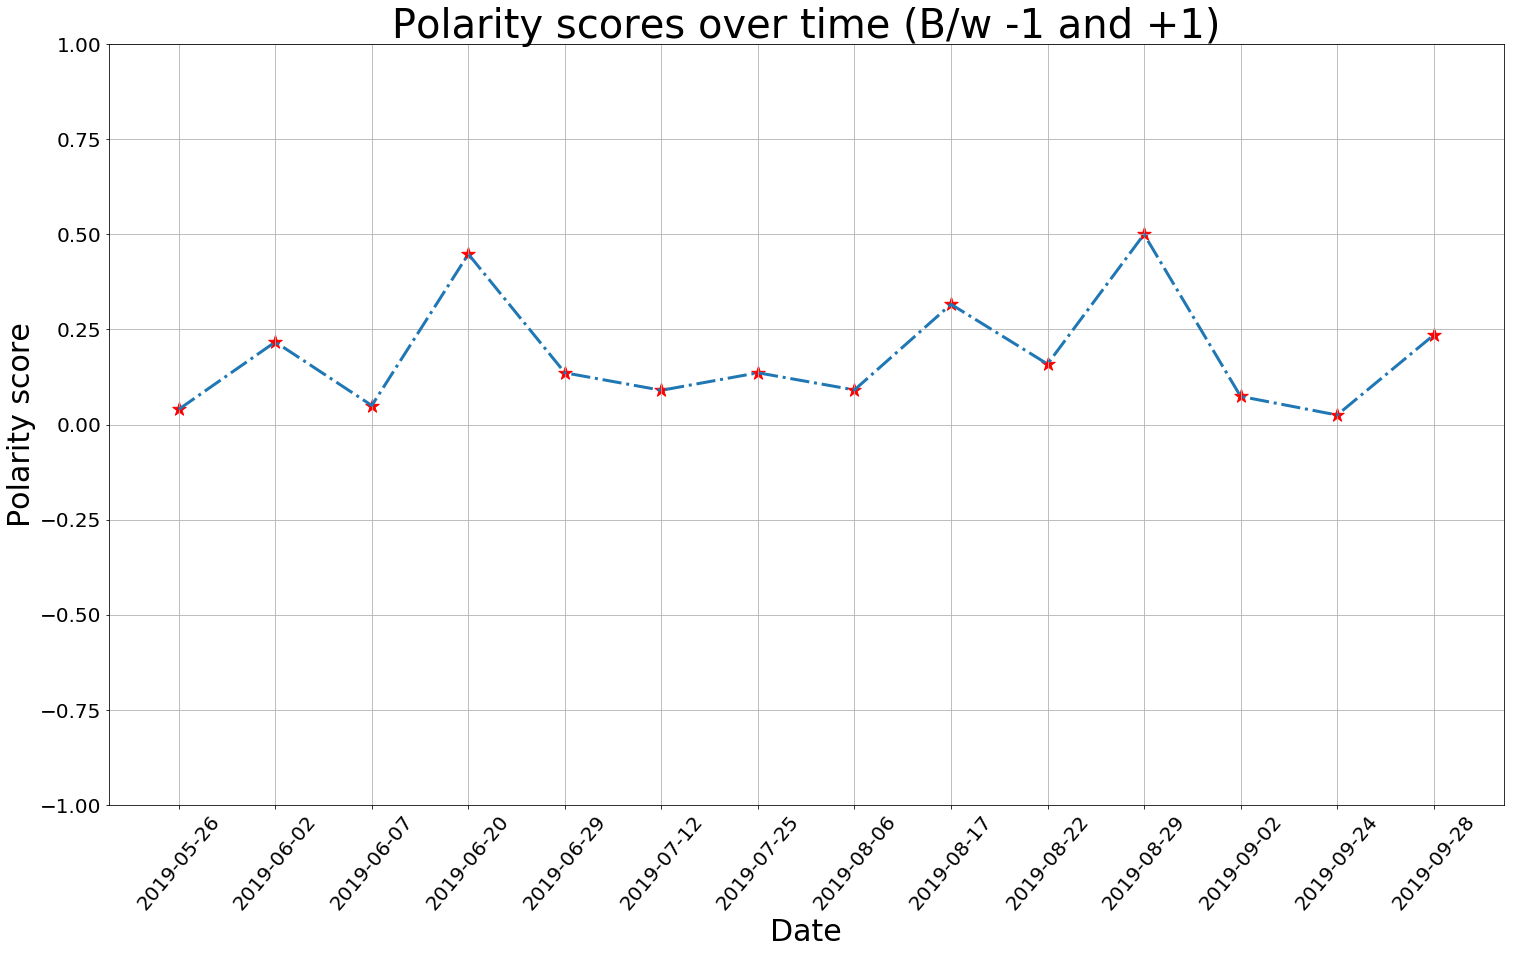

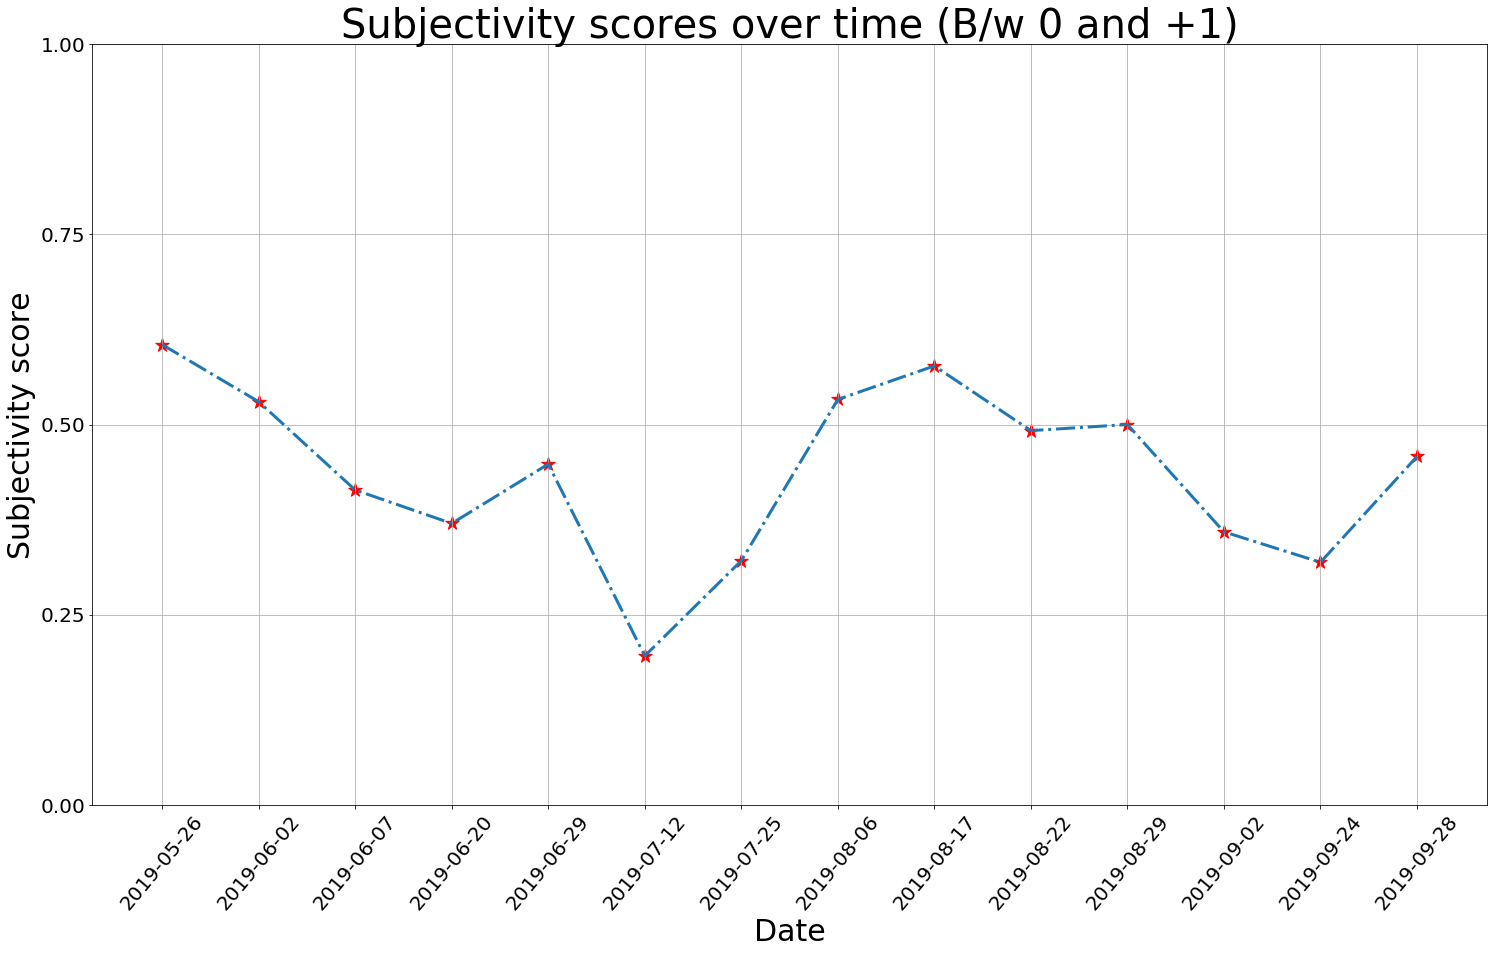

In [11]:
create_plots(df_with_sentiment)

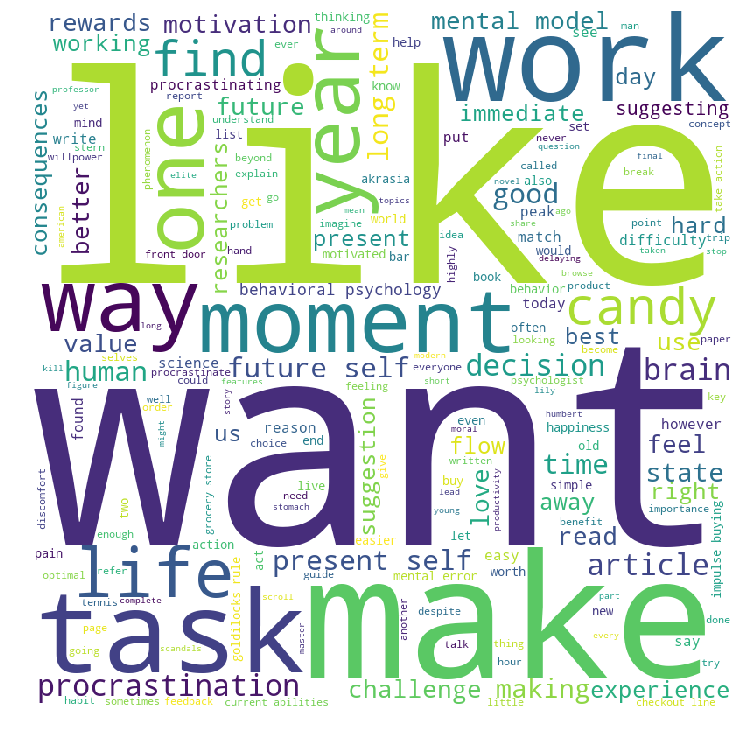

In [12]:
create_wordcloud(df_with_sentiment)